<a href="https://colab.research.google.com/github/hayata1996/kaggle/blob/main/kaggle_obesity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **クラス作成**
voting
lightgbm
knn
の二組をスタッキングする


In [ ]:
'''
lightgbmm & knn をスタッキングで自作する
train test の両者が非常に分布になっていることから過学習させた方が良いスコアになる？

'''

'\nlightgbmm & knn をスタッキングで自作する\ntrain test の両者が非常に分布になっていることから過学習させた方が良いスコアになる？\n\n'

お決まりの文句からスタート


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

必要そうなライブラリをまとめてインストール
不要なものが混じっているかも


In [ ]:
# データの前処理と分割
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgbm
import scipy.stats as ss
from scipy import interp
from scipy.stats import randint as sp_randint, uniform
from scipy.stats import mode
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix,  roc_curve, precision_recall_curve, accuracy_score, roc_auc_score, auc, classification_report
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from yellowbrick.classifier import DiscriminationThreshold
# optuna for lgbm
!pip install optuna
from optuna.samplers import TPESampler
import optuna


#EDAにはplotlyを使用するため追加で読み込む
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.tools as tls
import plotly.figure_factory as ff
#py.init_notebook_mode(connected=True)
#import squarify

データの読み込みとターゲットのコラムを変数に格納する


In [ ]:
#kaggleの場合は読み込みにパスが必要
#PATH = str("/kaggle/input/playground-series-s4e2")
#df = pd.read_csv(f"{PATH}/train.csv")

#データのファイル名を記入
train_csv = "train.csv"
test_csv = "test.csv"
target_column = "NObeyesdad"

train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)
target_column = target_column

EDAを行う

In [ ]:
display(train_df.info(), train_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

None

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [ ]:
display(test_df.info(),test_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13840 entries, 0 to 13839
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              13840 non-null  int64  
 1   Gender                          13840 non-null  object 
 2   Age                             13840 non-null  float64
 3   Height                          13840 non-null  float64
 4   Weight                          13840 non-null  float64
 5   family_history_with_overweight  13840 non-null  object 
 6   FAVC                            13840 non-null  object 
 7   FCVC                            13840 non-null  float64
 8   NCP                             13840 non-null  float64
 9   CAEC                            13840 non-null  object 
 10  SMOKE                           13840 non-null  object 
 11  CH2O                            13840 non-null  float64
 12  SCC                             

None

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


欠損値を確認する**0や-9999で補完されている場合は別途確認すべし


In [ ]:
train_df.isna().sum()

id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [ ]:
test_df.isna().sum()

id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
dtype: int64

不要な'id'を削除したのち目的変数を確認する **drop()のinplaceに関する中はリンクを確認。https://qiita.com/making111/items/f9bbe8acf765223587f7

In [ ]:
train_df.drop(columns=["id"], inplace=True)
test_df.drop(columns=["id"], inplace=True)
train_df[target_column].describe()

count                20758
unique                   7
top       Obesity_Type_III
freq                  4046
Name: NObeyesdad, dtype: object

In [ ]:
train_df[target_column].unique()

array(['Overweight_Level_II', 'Normal_Weight', 'Insufficient_Weight',
       'Obesity_Type_III', 'Obesity_Type_II', 'Overweight_Level_I',
       'Obesity_Type_I'], dtype=object)

In [ ]:
# 2 datasets outcome is two value variable yes1 or no0
#D = data[(data['Outcome'] != 0)]
#H = data[(data['Outcome'] == 0)]
#今回は七個のカテゴリからなるターゲットである

#------------COUNT-----------------------
def target_count(data, target_column):
    trace = go.Bar( x = data[target_column].value_counts().values.tolist(),
                    y = data[target_column].unique(),
                    orientation = 'h',
                    text=data[target_column].value_counts().values.tolist(),
                    textfont=dict(size=15),
                    textposition = 'auto',
                    opacity = 0.8,marker=dict(

                    line=dict(color='#000000',width=1.5)))

    layout = dict(title =  'Count of target variable')

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

#------------PERCENTAGE-------------------
def target_percent(data, target_column):
    trace = go.Pie(labels = train_df[target_column].unique(), values = data[target_column].value_counts(),
                   textfont=dict(size=15), opacity = 0.8,
                   marker=dict(
                               line=dict(color='#000000', width=1.5)))


    layout = dict(title =  'Distribution of Outcome variable')

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

In [ ]:
target_count(train_df, target_column)
target_percent(train_df, target_column)

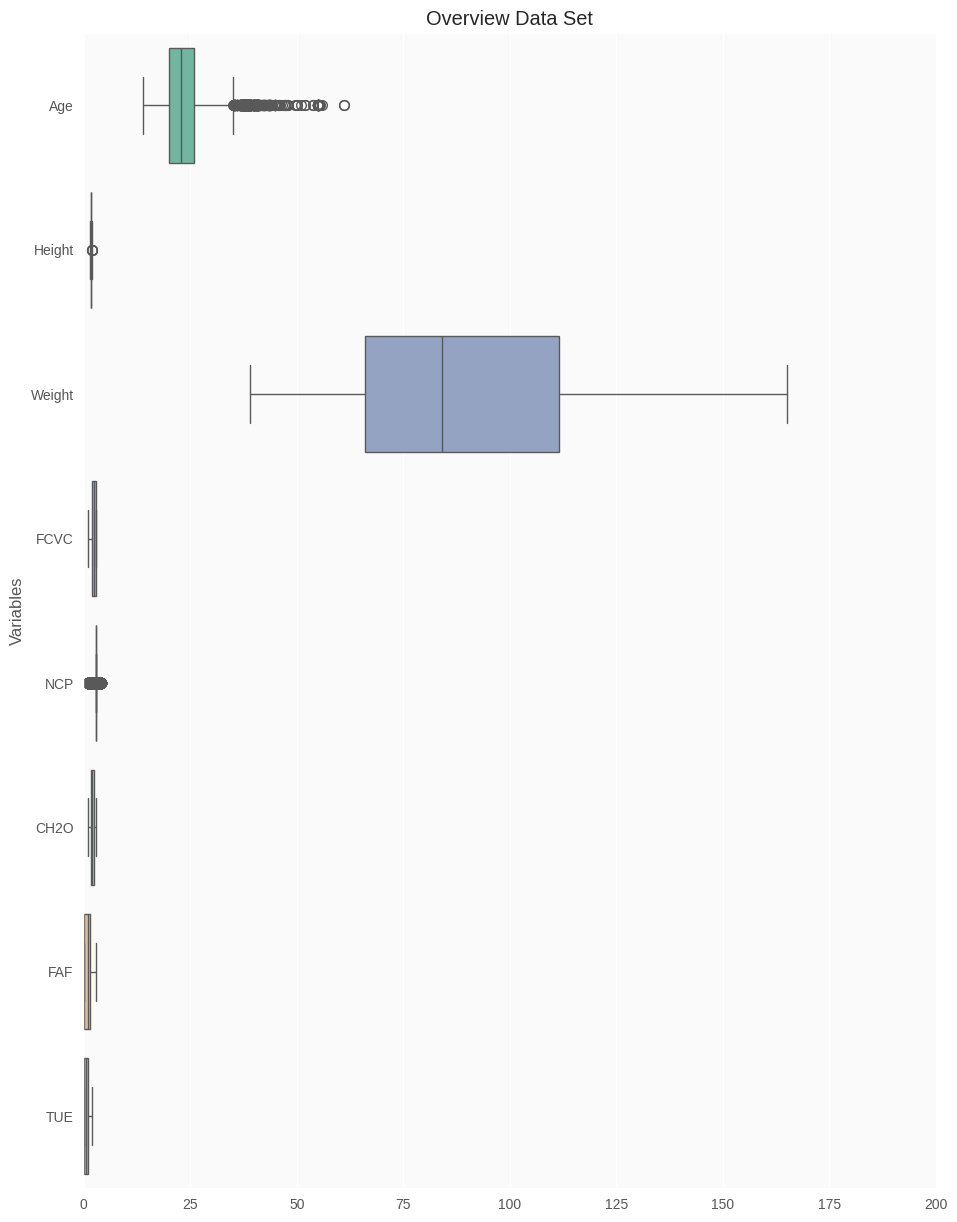

In [ ]:
plt.style.use('ggplot') # Using ggplot2 style visuals

f, ax = plt.subplots(figsize=(11, 15))

ax.set_facecolor('#fafafa')
ax.set(xlim=(-.05, 200))
plt.ylabel('Variables')
plt.title("Overview Data Set")
ax = sns.boxplot(data = train_df,
  orient = 'h',
  palette = 'Set2')

データ間の相関


In [ ]:
def correlation_plot(data):
    #correlation
    correlation = data.corr()
    #tick labels
    matrix_cols = correlation.columns.tolist()
    #convert to array
    corr_array  = np.array(correlation)
    trace = go.Heatmap(z = corr_array,
                       x = matrix_cols,
                       y = matrix_cols,
                       colorscale='Viridis',
                       colorbar   = dict() ,
                      )
    layout = go.Layout(dict(title = 'Correlation Matrix for variables',
                            #autosize = False,
                            #height  = 1400,
                            #width   = 1600,
                            margin  = dict(r = 0 ,l = 100,
                                           t = 0,b = 100,
                                         ),
                            yaxis   = dict(tickfont = dict(size = 9)),
                            xaxis   = dict(tickfont = dict(size = 9)),
                           )
                      )
    fig = go.Figure(data = [trace],layout = layout)
    py.iplot(fig)

correlation_plot(train_df)

<ipython-input-18-0aba2be39801>:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



In [ ]:
def plot_feat1_feat2(feat1, feat2) :
    D = data[(data['Outcome'] != 0)]
    H = data[(data['Outcome'] == 0)]
    trace0 = go.Scatter(
        x = D[feat1],
        y = D[feat2],
        name = 'diabetic',
        mode = 'markers',
        marker = dict(color = '#FFD700',
            line = dict(
                width = 1)))

    trace1 = go.Scatter(
        x = H[feat1],
        y = H[feat2],
        name = 'healthy',
        mode = 'markers',
        marker = dict(color = '#7EC0EE',
            line = dict(
                width = 1)))

    layout = dict(title = feat1 +" "+"vs"+" "+ feat2,
                  yaxis = dict(title = feat2,zeroline = False),
                  xaxis = dict(title = feat1, zeroline = False)
                 )

    plots = [trace0, trace1]

    fig = dict(data = plots, layout=layout)
    py.iplot(fig)

In [ ]:
#X = train_df.drop(target_column,1)
#y = train_df[target_column]

according to chatGPT python, below uses xgboost and knn insread. I modify parameter because is not as good as it is supposed to be. I use previous best parameter instead.

xgb_2 = XGBClassifier(
    learning_rate =0.01,
    n_estimators=5000,
    early_stopping_rounds=50,
    max_depth=4,
    min_child_weight=0.5,
    gamma=0.2,
    colsample_bytree=0.7,
    subsample=0.7,
    reg_alpha=1,
    objective= 'multi:softprob',
    nthread=-1,
    random_state=42

KNN is still going to use randomsearch, while xgboost uses previous best prams.




In [ ]:
#refer this link
#https://www.kaggle.com/code/akhiljethwa/playground-s4e2-eda-modeling-91-0

def objective(trial):
    """
    Objective function to be minimized.
    """
    param = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "num_class": 7,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgbm.LGBMClassifier(**param)
    gbm.fit(X_train_encoded_scaled, y_train)
    preds = gbm.predict(X_test_encoded_scaled)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

In [ ]:
#n_trials=200だとかなり時間かかる30分？
sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="lightgbm", direction="maximize", sampler=sampler)
#study.optimize(objective, n_trials=200)
study.optimize(objective, n_trials=100)

[I 2024-02-27 13:25:09,166] A new study created in memory with name: lightgbm
[I 2024-02-27 13:25:10,172] Trial 0 finished with value: 0.8516377649325626 and parameters: {'lambda_l1': 5.6649755830282306e-05, 'lambda_l2': 0.030403280126677572, 'num_leaves': 2, 'feature_fraction': 0.5813995435791038, 'bagging_fraction': 0.48805353449026784, 'bagging_freq': 1, 'min_child_samples': 22}. Best is trial 0 with value: 0.8516377649325626.
[I 2024-02-27 13:25:15,228] Trial 1 finished with value: 0.9017341040462428 and parameters: {'lambda_l1': 1.2883876209377052e-05, 'lambda_l2': 3.72312200494449e-05, 'num_leaves': 139, 'feature_fraction': 0.6515167086419769, 'bagging_fraction': 0.8111317002380557, 'bagging_freq': 2, 'min_child_samples': 89}. Best is trial 1 with value: 0.9017341040462428.
[I 2024-02-27 13:25:19,439] Trial 2 finished with value: 0.9048651252408478 and parameters: {'lambda_l1': 1.763958399884789e-08, 'lambda_l2': 0.010819509974097813, 'num_leaves': 108, 'feature_fraction': 0.7352

In [ ]:
print('Best parameters:', study.best_params)

In [ ]:
print('Best value:', study.best_value)

In [ ]:
print('Best trial:', study.best_trial)

In [ ]:
from xgboost import XGBClassifier

# データの前処理と分割
def preprocess_and_split(df, target_column):
    le = LabelEncoder()
    le.fit(df[target_column])
    df[target_column] = le.transform(df[target_column])
    X = df.drop(columns=[target_column])
    y = df[target_column].values
    # カテゴリカルカラムの検出
    categorical_columns = X.select_dtypes(include=['object', 'category']).columns
    numeric_columns = X.select_dtypes(exclude=['object', 'category']).columns

    # Label Encoding for all categorical features for use in LightGBM
    #this time for xgboost
    for col in categorical_columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # One-Hot Encoding の適用 (for KNN)
    encoder = ColumnTransformer(transformers=[('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_columns)], remainder='passthrough')
    X_train_encoded = encoder.fit_transform(X_train)
    X_test_encoded = encoder.transform(X_test)

    return X_train, X_test, y_train, y_test, X_train_encoded, X_test_encoded, numeric_columns, categorical_columns

def voting_classifier(clf1,clf2,clf3, X_train_encoded_scaled,y_test):
#>>> clf1 = LogisticRegression(random_state=1)
#>>> clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
#>>> clf3 = GaussianNB()

    eclf = VotingClassifier(
        estimators=[('xgb', clf1), ('knn', clf2), ('lgbm', clf3)],
        voting='soft', weights=[2,1,2])
    return eclf
'''
    eclf = VotingClassifier(
        estimators=[('xgb', clf1), ('knn', clf2), ('lgbm', clf3)],
        voting='hard')

    #この交差検証が遅い。アンサンブルモデルを得るだけならここは無しでも良い15分以上
    for clf, label in zip([clf1, clf2, clf3, eclf], ['xgboost', 'knn', 'lgbm', 'Ensemble']):
        scores = cross_val_score(clf, X_train_encoded_scaled, y_train, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    return eclf
'''

def tune_and_train(X_train, X_test, y_train, y_test, X_train_encoded, X_test_encoded, numeric_columns, categorical_columns):
    '''
    # Data scaling (for numeric data)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Scaling the encoded data for KNN
    X_train_encoded_scaled = scaler.fit_transform(X_train_encoded)
    X_test_encoded_scaled = scaler.transform(X_test_encoded)
'''
    # Model initialization
    #xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    knn = KNeighborsClassifier()
    '''
    #X_trainで最適化した係数
    lgbm_model = lgbm.LGBMClassifier(lambda_l1=3.341919070318744e-06,
                               lambda_l2=0.12691529280491062,
                               num_leaves=28,
                               feature_fraction=0.6687361157055431,
                               bagging_fraction=0.9451573018558573,
                               bagging_freq=3,
                               min_child_samples=32)
    '''
    #X_train_encoded_scaledで最適化した係数
    lgbm_model = lgbm.LGBMClassifier(lambda_l1=0.0013595281785726795,
                               lambda_l2=0.7379430252894568,
                               num_leaves=19,
                               feature_fraction=0.6888431914389018,
                               bagging_fraction=0.9428538586096062,
                               bagging_freq=6,
                               min_child_samples=67)

    # Parameter search
    # actually, this time xgboost uses pre mode prams. do not search.
    xgb_best_model = XGBClassifier(
        learning_rate =0.01,
        #n_estimators=5000,
        n_estimators = 2000,
        #early_stopping_rounds=50,
        max_depth=4,
        min_child_weight=0.5,
        gamma=0.2,
        colsample_bytree=0.7,
        subsample=0.7,
        reg_alpha=1,
        objective= 'multi:softprob',
        nthread=-1,
        random_state=42
    )

    #xgb_best_model.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)])
    xgb_best_model.fit(X_train_encoded_scaled, y_train, eval_set=[(X_test_encoded_scaled, y_test)])
    acc_train = accuracy_score(y_train, xgb_best_model.predict(X_train_encoded_scaled))
    acc_val = accuracy_score(y_test, xgb_best_model.predict(X_test_encoded_scaled))
    print(f"model: xgb_best_model\ntrain_accuracy: {acc_train:.4f}\ntest_accuracy: {acc_val:.4f}")

    #this time I do not use them
    #this made 91.1% accuracy before. trustworthly.
    xgb_param_dist = {
        'max_depth': sp_randint(3, 10),
        'learning_rate': uniform(0.01, 0.2),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4),
        'n_estimators': sp_randint(100, 1000),
        'min_child_weight': sp_randint(1, 10),
    }

    knn_param_dist = {
        'n_neighbors': sp_randint(1, 30),
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    }

    #lightgbm
    lgbm_model.fit(X_train_encoded_scaled, y_train)

    # XGBoost training
    #xgb_random_search = RandomizedSearchCV(xgb, param_distributions=xgb_param_dist, n_iter=3, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
    #xgb_best_model = xgb_random_search.fit(X_train_scaled, y_train)

    # KNN training
    knn_random_search = RandomizedSearchCV(knn, param_distributions=knn_param_dist, n_iter=3, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
    knn_best_model = knn_random_search.fit(X_train_encoded_scaled, y_train)

    # Predictions using the best parameters from XGBoost and KNN
    #xgb_pred = xgb_best_model.predict(X_test_scaled)
    xgb_pred = xgb_best_model.predict(X_test_encoded_scaled)
    knn_pred = knn_best_model.predict(X_test_encoded_scaled)
    lgbm_pred = lgbm_model.predict(X_test_encoded_scaled)
    print(f'what are in xgb_pred & knn_pred & lgbm_pred: {xgb_pred}, {knn_pred}, {lgbm_pred}')

    #print out accuracy of both xgb&knn
    acc_train = accuracy_score(y_train, xgb_best_model.predict(X_train_encoded_scaled))
    acc_val = accuracy_score(y_test, xgb_best_model.predict(X_test_encoded_scaled))
    print(f"model: xgb_best_model_scaled\ntrain_accuracy: {acc_train:.4f}\ntest_accuracy: {acc_val:.4f}")
    acc_train = accuracy_score(y_train, knn_best_model.predict(X_train_encoded_scaled))
    acc_val = accuracy_score(y_test, knn_best_model.predict(X_test_encoded_scaled))
    print(f"model: knn_best_model_scaled\ntrain_accuracy: {acc_train:.4f}\ntest_accuracy: {acc_val:.4f}")
    acc_train = accuracy_score(y_train, lgbm_model.predict(X_train_encoded_scaled))
    acc_val = accuracy_score(y_test, lgbm_model.predict(X_test_encoded_scaled))
    print(f"model: lgbm_model_scaled\ntrain_accuracy: {acc_train:.4f}\ntest_accuracy: {acc_val:.4f}")


    # Ensemble (average voting) this is not suitable for classification. for regression?
    #final_pred = np.round((xgb_pred + knn_pred) / 2).astype(int)
    eclf_model = voting_classifier(xgb_best_model, knn_best_model, lgbm_model, X_train_encoded_scaled, y_test)

    # Calculate accuracy
    #accuracy = accuracy_score(y_test, final_pred)
    #return accuracy, knn_best_model.best_params_, eclf_model
    return knn_best_model.best_params_, eclf_model

df = train_df
val_df = test_df
xgb_pred = []
knn_pred = []
lgbm_pred = []

X_train, X_test, y_train, y_test, X_train_encoded, X_test_encoded, numeric_columns, categorical_columns = preprocess_and_split(df, target_column)

# Data scaling (for numeric data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

    # Scaling the encoded data for K
X_train_encoded_scaled = scaler.fit_transform(X_train_encoded)
X_test_encoded_scaled = scaler.transform(X_test_encoded)


#accuracy, knn_best_params, eclf_model = tune_and_train(X_train, X_test, y_train, y_test, X_train_encoded, X_test_encoded, numeric_columns, categorical_columns)
knn_best_params, eclf_model = tune_and_train(X_train, X_test, y_train, y_test, X_train_encoded, X_test_encoded, numeric_columns, categorical_columns)
#print(f'Accuracy: {accuracy}')
#print(f'Best parameters for LGBM: {lgbm_best_params}')
print(f'Best parameters for KNN: {knn_best_params}')
#print(eclf_model)
eclf_model.fit(X_train_encoded_scaled, y_train)
#eclf_model_pred = eclf_model.predict(X_test_encoded_scaled)
acc_train = accuracy_score(y_train, eclf_model.predict(X_train_encoded_scaled))
acc_val = accuracy_score(y_test, eclf_model.predict(X_test_encoded_scaled))
print(f"model: eclf_model\ntrain_accuracy: {acc_train:.4f}\ntest_accuracy: {acc_val:.4f}")


[0]	validation_0-mlogloss:1.92642
[1]	validation_0-mlogloss:1.90811
[2]	validation_0-mlogloss:1.88824
[3]	validation_0-mlogloss:1.86976
[4]	validation_0-mlogloss:1.84892
[5]	validation_0-mlogloss:1.83171
[6]	validation_0-mlogloss:1.81648
[7]	validation_0-mlogloss:1.79923
[8]	validation_0-mlogloss:1.78224
[9]	validation_0-mlogloss:1.76541
[10]	validation_0-mlogloss:1.74984
[11]	validation_0-mlogloss:1.73376
[12]	validation_0-mlogloss:1.71766
[13]	validation_0-mlogloss:1.70436
[14]	validation_0-mlogloss:1.68900
[15]	validation_0-mlogloss:1.67421
[16]	validation_0-mlogloss:1.66005
[17]	validation_0-mlogloss:1.64710
[18]	validation_0-mlogloss:1.63543
[19]	validation_0-mlogloss:1.62060
[20]	validation_0-mlogloss:1.60718
[21]	validation_0-mlogloss:1.59510
[22]	validation_0-mlogloss:1.58022
[23]	validation_0-mlogloss:1.56868
[24]	validation_0-mlogloss:1.55701
[25]	validation_0-mlogloss:1.54313
[26]	validation_0-mlogloss:1.53051
[27]	validation_0-mlogloss:1.51898
[28]	validation_0-mlogloss:1.5

In [ ]:
# Data scaling (for numeric data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

    # Scaling the encoded data for K
X_train_encoded_scaled = scaler.fit_transform(X_train_encoded)
X_test_encoded_scaled = scaler.transform(X_test_encoded)
eclf_model.fit(X_train_encoded_scaled, y_train)
#eclf_model_pred = eclf_model.predict(X_test_encoded_scaled)
acc_train = accuracy_score(y_train, eclf_model.predict(X_train_encoded_scaled))
acc_val = accuracy_score(y_test, eclf_model.predict(X_test_encoded_scaled))
print(f"model: eclf_model\ntrain_accuracy: {acc_train:.4f}\ntest_accuracy: {acc_val:.4f}")


[LightGBM] [Warning] feature_fraction is set=0.6888431914389018, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6888431914389018
[LightGBM] [Warning] lambda_l2 is set=0.7379430252894568, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7379430252894568
[LightGBM] [Warning] lambda_l1 is set=0.0013595281785726795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013595281785726795
[LightGBM] [Warning] bagging_fraction is set=0.9428538586096062, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9428538586096062
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6888431914389018, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6888431914389018
[LightGBM] [Warning] lambda_l2 is set=0.7379430252894568, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7379430252894568
[LightGBM] [Warning] lambda_l1

code to submit csv includes predictions.


In [ ]:
print(xgb_pred)



In [ ]:
knn_pred = []

In [ ]:
best = xgb_2
predictions = best.predict(X_test)
submission_data = pd.read_csv(f"{PATH}/sample_submission.csv")
submission_data["NObeyesdad"] = predictions
submission_data.replace(inverse_obese_dict, inplace=True)
submission_data.head(20)

初期の叩き台

In [ ]:
# データの前処理と分割
def preprocess_and_split(df, target_column):
    le = LabelEncoder()
    le.fit(df[target_column])
    df[target_column] = le.transform(df[target_column])
    X = df.drop(columns=[target_column])
    y = df[target_column].values
    # カテゴリカルカラムの検出
    categorical_columns = X.select_dtypes(include=['object', 'category']).columns
    numeric_columns = X.select_dtypes(exclude=['object', 'category']).columns

    # Label Encoding for all categorical features for use in LightGBM
    for col in categorical_columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # One-Hot Encoding の適用 (for KNN)
    encoder = ColumnTransformer(transformers=[('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_columns)], remainder='passthrough')
    X_train_encoded = encoder.fit_transform(X_train)
    X_test_encoded = encoder.transform(X_test)

    return X_train, X_test, y_train, y_test, X_train_encoded, X_test_encoded, numeric_columns, categorical_columns

# パラメータチューニングとモデルの訓練
def tune_and_train(X_train, X_test, y_train, y_test, X_train_encoded, X_test_encoded, numeric_columns, categorical_columns):
    # データの標準化 (数値データのみ)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # KNN用にエンコードされたデータをスケーリング
    X_train_encoded_scaled = scaler.fit_transform(X_train_encoded)
    X_test_encoded_scaled = scaler.transform(X_test_encoded)

    # モデルの初期化
    lgbm = LGBMClassifier(random_state=42)
    knn = KNeighborsClassifier()

    # パラメータの探索範囲
    lgbm_param_dist = {
        'num_leaves': sp_randint(20, 200),
        'min_child_samples': sp_randint(20, 500),
        'min_child_weight': uniform(0.01, 0.1),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4),
    }
    knn_param_dist = {
        'n_neighbors': sp_randint(1, 30),
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    }

    # LGBMの訓練
    lgbm_random_search = RandomizedSearchCV(lgbm, param_distributions=lgbm_param_dist, n_iter=3, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
    lgbm_best_model = lgbm_random_search.fit(X_train, y_train)

    # KNNの訓練
    knn_random_search = RandomizedSearchCV(knn, param_distributions=knn_param_dist, n_iter=3, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
    knn_best_model = knn_random_search.fit(X_train_encoded_scaled, y_train)

    # LGBMとKNNの最適なパラメータを使用して予測
    lgbm_pred = lgbm_best_model.predict(X_test_scaled)
    knn_pred = knn_best_model.predict(X_test_encoded_scaled)
    print(f'最適パラメタlとkは：{lgbm_pred, knn_pred}')

    # アンサンブル（平均投票）
    final_pred = np.round((lgbm_pred + knn_pred) / 2).astype(int)
    # Calculate accuracy
    accuracy = accuracy_score(y_test, final_pred)
    print(f'Accuracy: {accuracy}')
    print(f'Best parameters for LGBM: {lgbm_best_params}')
    print(f'Best parameters for KNN: {knn_best_params}')

    test_pred = lgbm_best_model.predict(test_df)
    print

    return accuracy, lgbm_best_model.best_params_, knn_best_model.best_params_


df = train_df
val_df = test_df

# この例では、直接データフレーム 'df' とターゲット列名 'target_column' を指定します。
X_train, X_test, y_train, y_test, X_train_encoded, X_test_encoded, numeric_columns, categorical_columns = preprocess_and_split(df, target_column)
accuracy, lgbm_best_params, knn_best_params = tune_and_train(X_train, X_test, y_train, y_test, X_train_encoded, X_test_encoded, numeric_columns, categorical_columns)



In [ ]:
#アンサンブルする際に与えるデータが異なること困る
#X_train or X_train_scaled or X_train_scaled_encorded?
#上に修正バージョン。このプログラムはエラーでる。

from xgboost import XGBClassifier

# データの前処理と分割
def preprocess_and_split(df, target_column):
    le = LabelEncoder()
    le.fit(df[target_column])
    df[target_column] = le.transform(df[target_column])
    X = df.drop(columns=[target_column])
    y = df[target_column].values
    # カテゴリカルカラムの検出
    categorical_columns = X.select_dtypes(include=['object', 'category']).columns
    numeric_columns = X.select_dtypes(exclude=['object', 'category']).columns

    # Label Encoding for all categorical features for use in LightGBM
    #this time for xgboost
    for col in categorical_columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # One-Hot Encoding の適用 (for KNN)
    encoder = ColumnTransformer(transformers=[('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_columns)], remainder='passthrough')
    X_train_encoded = encoder.fit_transform(X_train)
    X_test_encoded = encoder.transform(X_test)

    return X_train, X_test, y_train, y_test, X_train_encoded, X_test_encoded, numeric_columns, categorical_columns

def voting_classifier(clf1,clf2,clf3):
#>>> clf1 = LogisticRegression(random_state=1)
#>>> clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
#>>> clf3 = GaussianNB()

    eclf = VotingClassifier(
        estimators=[('xgb', clf1), ('knn', clf2), ('lgbm', clf3)],
        voting='hard')

    for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
        scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    return eclf


def tune_and_train(X_train, X_test, y_train, y_test, X_train_encoded, X_test_encoded, numeric_columns, categorical_columns):
    # Data scaling (for numeric data)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Scaling the encoded data for KNN
    X_train_encoded_scaled = scaler.fit_transform(X_train_encoded)
    X_test_encoded_scaled = scaler.transform(X_test_encoded)

    # Model initialization
    #xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    knn = KNeighborsClassifier()
    lgbm_model = lgbm.LGBMClassifier(lambda_l1=3.341919070318744e-06,
                               lambda_l2=0.12691529280491062,
                               num_leaves=28,
                               feature_fraction=0.6687361157055431,
                               bagging_fraction=0.9451573018558573,
                               bagging_freq=3,
                               min_child_samples=32)

    # Parameter search
    # actually, this time xgboost uses pre mode prams. do not search.
    xgb_best_model = XGBClassifier(
        learning_rate =0.01,
        #n_estimators=5000,
        n_estimators = 2000,
        early_stopping_rounds=50,
        max_depth=4,
        min_child_weight=0.5,
        gamma=0.2,
        colsample_bytree=0.7,
        subsample=0.7,
        reg_alpha=1,
        objective= 'multi:softprob',
        nthread=-1,
        random_state=42
    )

    #xgb_best_model.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)])
    xgb_best_model.fit(X_train_encoded_scaled, y_train, eval_set= [(X_test_encoded_scaled, y_test)])
    acc_train = accuracy_score(y_train, xgb_best_model.predict(X_train_encoded_scaled))
    acc_val = accuracy_score(y_test, xgb_best_model.predict(X_test_encoded_scaled))
    print(f"model: xgb_best_model\ntrain_accuracy: {acc_train:.4f}\ntest_accuracy: {acc_val:.4f}")

    #this time I do not use them
    #this made 91.1% accuracy before. trustworthly.
    xgb_param_dist = {
        'max_depth': sp_randint(3, 10),
        'learning_rate': uniform(0.01, 0.2),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4),
        'n_estimators': sp_randint(100, 1000),
        'min_child_weight': sp_randint(1, 10),
    }

    knn_param_dist = {
        'n_neighbors': sp_randint(1, 30),
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    }

    #lightgbm
    lgbm_model.fit(X_train_encoded_scaled, y_train)

    # XGBoost training
    #xgb_random_search = RandomizedSearchCV(xgb, param_distributions=xgb_param_dist, n_iter=3, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
    #xgb_best_model = xgb_random_search.fit(X_train_scaled, y_train)

    # KNN training
    knn_random_search = RandomizedSearchCV(knn, param_distributions=knn_param_dist, n_iter=3, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
    knn_best_model = knn_random_search.fit(X_train_encoded_scaled, y_train)

    # Predictions using the best parameters from XGBoost and KNN
    #xgb_pred = xgb_best_model.predict(X_test_scaled)
    xgb_pred = xgb_best_model.predict(X_test_encoded_scaled)
    knn_pred = knn_best_model.predict(X_test_encoded_scaled)
    lgbm_pred = lgbm_model.predict(X_test_encoded_scaled)
    print(f'what are in xgb_pred & knn_pred: {xgb_pred}, {knn_pred}, {lgbm_pred}')

    #print out accuracy of both xgb&knn
    acc_train = accuracy_score(y_train, xgb_best_model.predict(X_train_encoded_scaled))
    acc_val = accuracy_score(y_test, xgb_best_model.predict(X_test_encoded_scaled))
    print(f"model: xgb_best_model_scaled\ntrain_accuracy: {acc_train:.4f}\ntest_accuracy: {acc_val:.4f}")
    acc_train = accuracy_score(y_train, knn_best_model.predict(X_train_encoded_scaled))
    acc_val = accuracy_score(y_test, knn_best_model.predict(X_test_encoded_scaled))
    print(f"model: knn_best_model_scaled\ntrain_accuracy: {acc_train:.4f}\ntest_accuracy: {acc_val:.4f}")
    acc_train = accuracy_score(y_train, lgbm_model.predict(X_train_encoded_scaled))
    acc_val = accuracy_score(y_test, lgbm_model.predict(X_test_encoded_scaled))
    print(f"model: lgbm_model_scaled\ntrain_accuracy: {acc_train:.4f}\ntest_accuracy: {acc_val:.4f}")


    # Ensemble (average voting) this is not suitable for classification. for regression?
    #final_pred = np.round((xgb_pred + knn_pred) / 2).astype(int)
    eclf_model = voting_classifier(xgb_best_model, knn_best_model, lgbm_model)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, final_pred)
    return accuracy, knn_best_model.best_params_, eclf_model


df = train_df
val_df = test_df

X_train, X_test, y_train, y_test, X_train_encoded, X_test_encoded, numeric_columns, categorical_columns = preprocess_and_split(df, target_column)
accuracy, knn_best_params, eclf_model = tune_and_train(X_train, X_test, y_train, y_test, X_train_encoded, X_test_encoded, numeric_columns, categorical_columns)
print(f'Accuracy: {accuracy}')
#print(f'Best parameters for LGBM: {lgbm_best_params}')
print(f'Best parameters for KNN: {knn_best_params}')
print(eclf_model)

